### Importing the necessary Libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import seaborn as sns

### Importing the dataset

In [2]:
dataset = pd.read_csv(r'C:\Users\LENOVO\Documents\Post Graduation\data sets\dataset1-master\titanic_train.csv')
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Dropping the below columns as the 'PassengerId','Name' and'Ticket' are categorical and the unique values are equal to the number of rows. Hence thay are not useful in the analysis

In [3]:
dataset = dataset.drop(columns = ['PassengerId','Name','Ticket'])

In [4]:
dataset.shape

(891, 9)

### Checking for null values

In [5]:
dataset.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

### There are null values for the columns Age, Cabin and Embarked. Therefore treating the null values

In [6]:
import seaborn as sns
le = LabelEncoder()
sx = le.fit_transform(dataset['Sex'])
pd.Series(sx)
dataset['Sex'] = sx

In [7]:
dataset.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

#### Using mode to replace null in 'Cabin' column and encoding them

In [8]:
dataset['Cabin'] = dataset['Cabin'].fillna(dataset['Cabin'].mode()[0])

In [9]:
cb =  le.fit_transform(dataset['Cabin'])
pd.Series(cb)
dataset['Cabin'] = cb

In [10]:
dataset.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,7.2500,47,S
1,1,1,0,38.0,1,0,71.2833,81,C
2,1,3,0,26.0,0,0,7.9250,47,S
3,1,1,0,35.0,1,0,53.1000,55,S
4,0,3,1,35.0,0,0,8.0500,47,S


In [11]:
#### Using mode to replace null in 'Embarked' column and encoding them

In [12]:
dataset['Embarked'] = dataset['Embarked'].fillna(dataset['Embarked'].mode()[0])

In [13]:
em =  le.fit_transform(dataset['Embarked'])
pd.Series(em)
dataset['Embarked'] = em

### Age is not normally distribued, hence using median to replace null values.

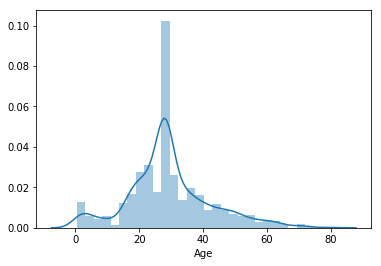

In [20]:
sns.distplot(dataset['Age'])

In [19]:
dataset['Age'] = dataset['Age'].fillna(dataset['Age'].median())

### The dataset has no null values to treat further

In [21]:
dataset.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    0
dtype: int64

## Checking for class imbalance

In [22]:
dataset['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

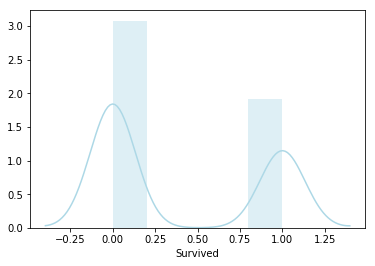

In [23]:
sns.distplot(dataset['Survived'],color = 'lightblue')

## Checking for correlation

In [24]:
corr_data = dataset.corr()
corr_data['Survived'].sort_values(ascending = False)

Survived    1.000000
Fare        0.257307
Cabin       0.175690
Parch       0.081629
SibSp      -0.035322
Age        -0.064910
Embarked   -0.167675
Pclass     -0.338481
Sex        -0.543351
Name: Survived, dtype: float64

#### Upon reviewing the correlation I see that Sex has highest negative correlation and the lowest correlation is with Parch, SibSp and Age

## Checking for multi-collenearity

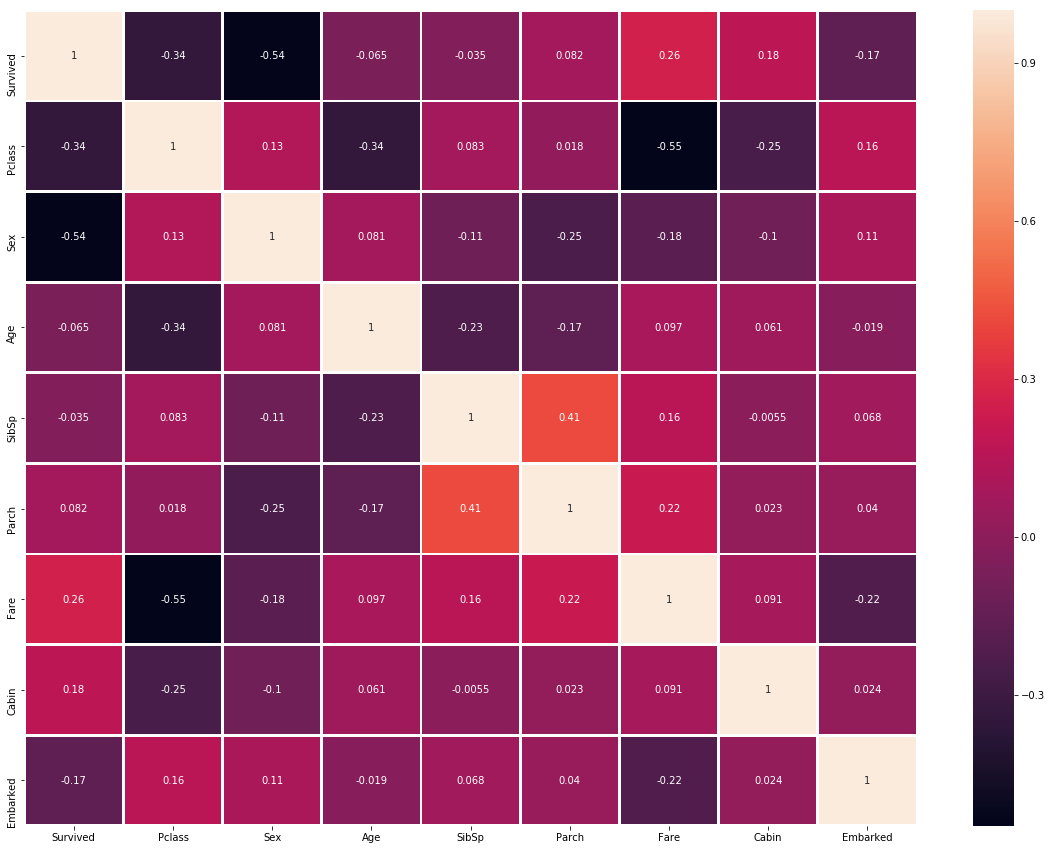

In [25]:
plt.figure(figsize = (20,15))
sns.heatmap(corr_data,annot =True,linewidths=2)

### There no multio collinearity problem

## Checking for Outliers in the continuous column

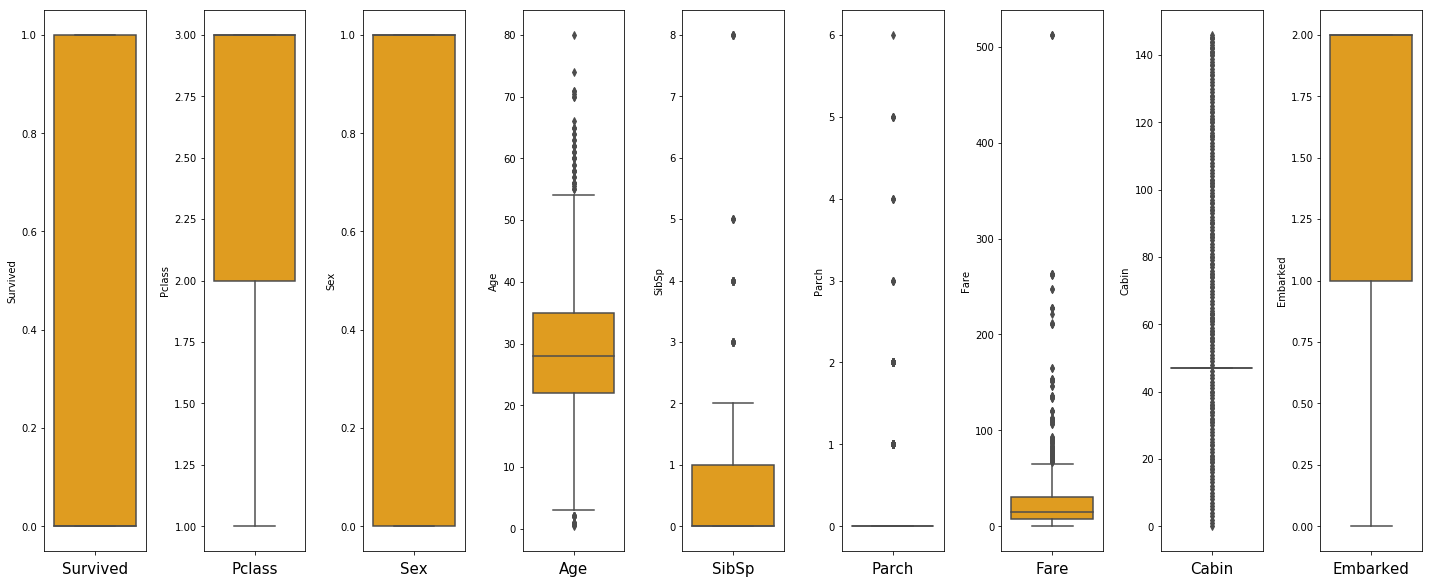

In [26]:
plt.figure(figsize = (20,80))
plotnum = 1

for i in dataset:
    if plotnum<= 90:
        sc = plt.subplot(10,9,plotnum)
        sns.boxplot(dataset[i],color = 'orange', orient ='v')
        plt.xlabel(i,fontsize = 15)
    plotnum+=1
plt.tight_layout()

### Upon review, I see that the data has outliers especially Age and Fare

## Checking for data distribution

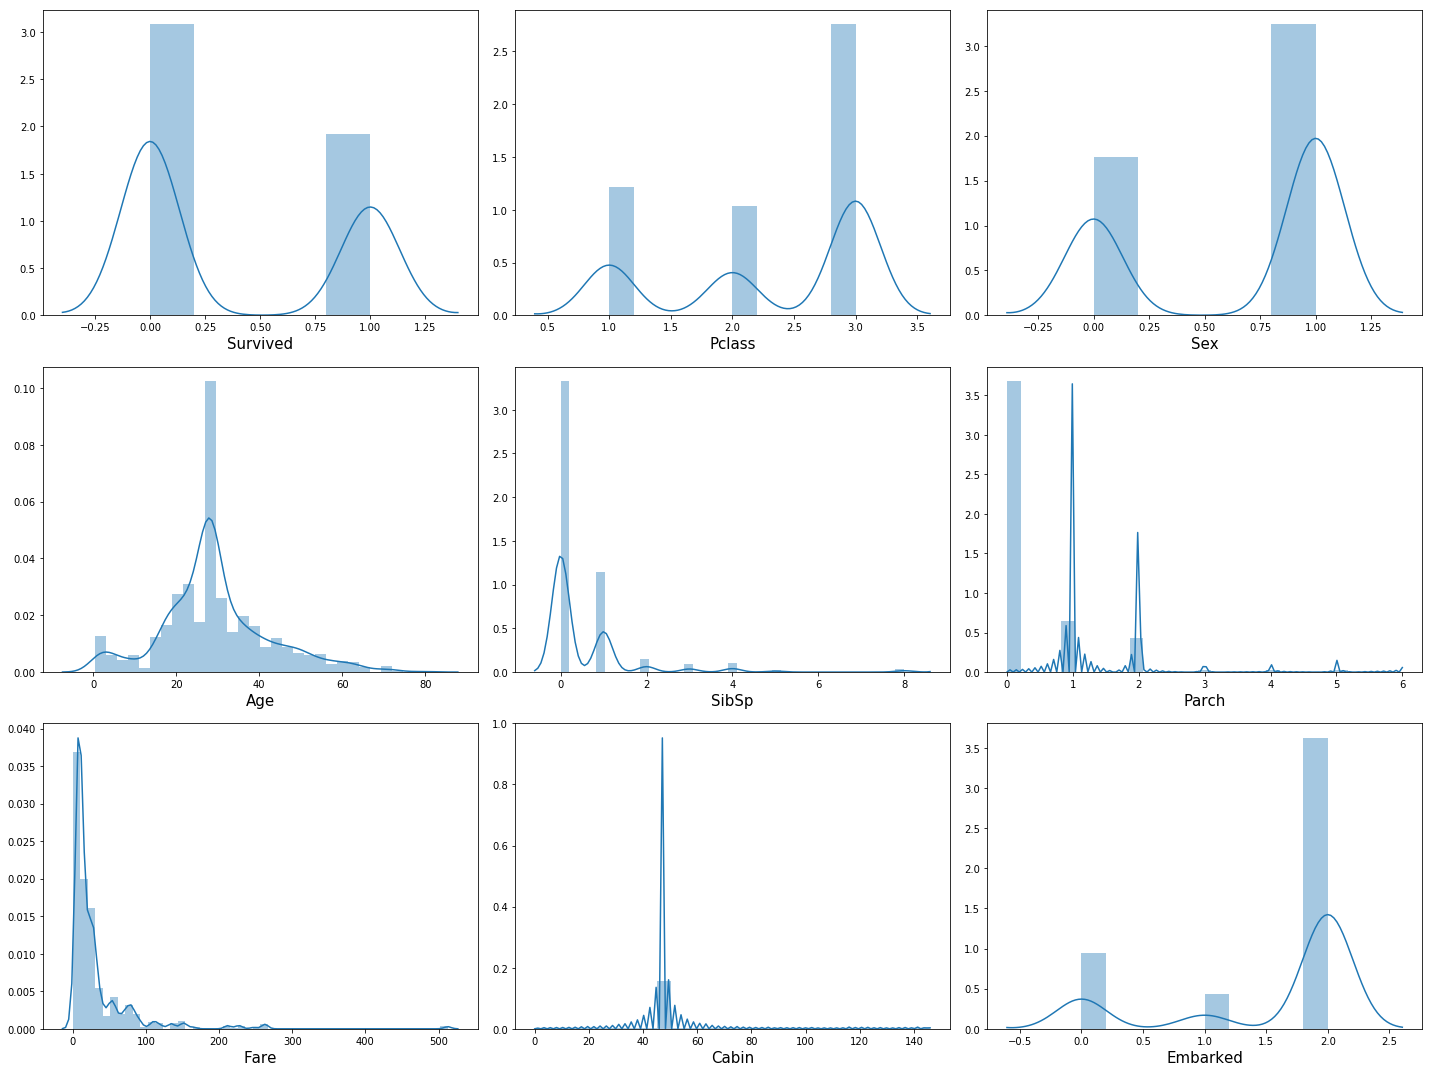

In [27]:
plt.figure(figsize = (20,15))
plotnum = 1

for i in dataset:
    if plotnum<= 9:
        sc = plt.subplot(3,3,plotnum)
        sns.distplot(dataset[i])
        plt.xlabel(i,fontsize = 15)
    plotnum+=1
plt.tight_layout()

### Except Age and fare most of the data are categorical. Age and fare are skewed data

### Checking the value counts for parch column and I see that some of the variables in feature has very minimal number. Therefore merging them to the majority variable '0'

In [28]:
dataset['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [29]:
dataset['Parch'] = np.where(dataset['Parch']== 3,0,
                           np.where(dataset['Parch']==4,0,
                                    np.where(dataset['Parch']==5,0,
                                            np.where(dataset['Parch']==6,0,dataset['Parch']))))

## Using the z-score method to remove the outliers

In [30]:
from scipy.stats import zscore
z = np.abs(zscore(dataset))
z

array([[0.78927234, 0.82737724, 0.73769513, ..., 0.50244517, 0.28188124,
        0.58595414],
       [1.2669898 , 1.56610693, 1.35557354, ..., 0.78684529, 1.16154512,
        1.9423032 ],
       [1.2669898 , 0.82737724, 1.35557354, ..., 0.48885426, 0.28188124,
        0.58595414],
       ...,
       [0.78927234, 0.82737724, 1.35557354, ..., 0.17626324, 0.28188124,
        0.58595414],
       [1.2669898 , 1.56610693, 0.73769513, ..., 0.04438104, 0.27001707,
        1.9423032 ],
       [0.78927234, 0.82737724, 0.73769513, ..., 0.49237783, 0.28188124,
        0.67817453]])

In [31]:
z_ds = dataset[(z<3).all(axis = 1)]
print(dataset.shape)
print(z_ds.shape)

(891, 9)
(800, 9)


### I am seeing 9% data loss and its par. hence proceeding with removing the outliers

In [32]:
(807/891)*100

90.57239057239057

### After the outlier removal I still see that there is a lot of outlier witht the Fare column

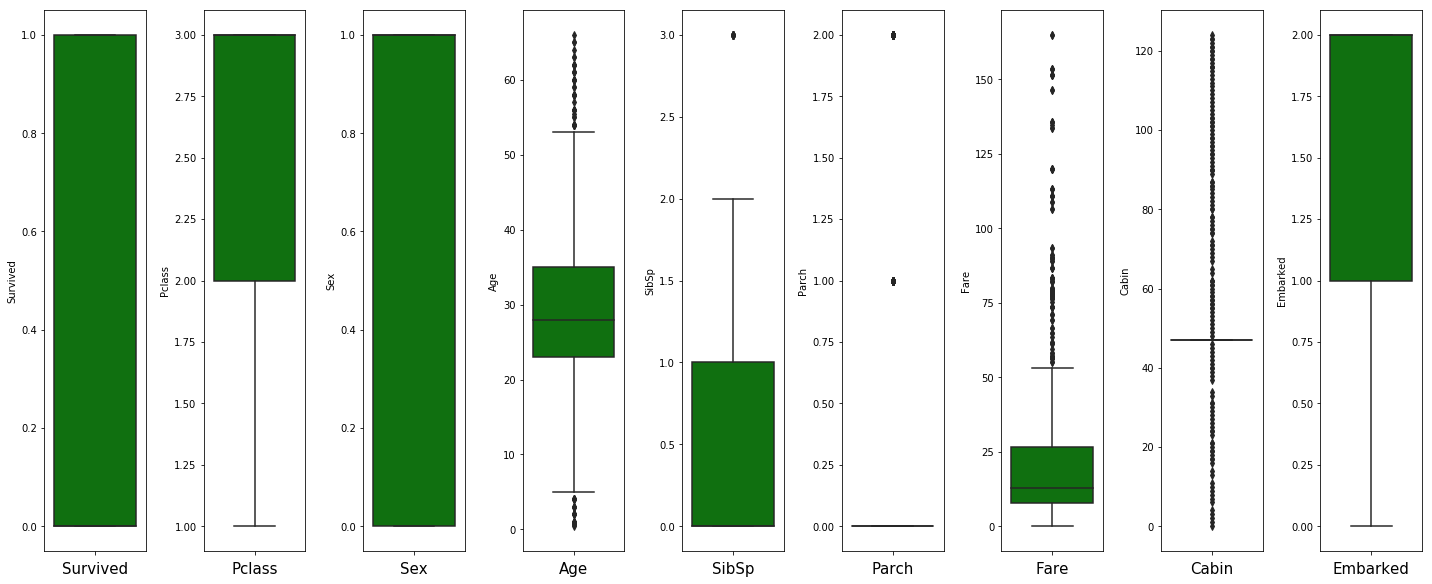

In [33]:
plt.figure(figsize = (20,80))
plotnum = 1

for i in z_ds:
    if plotnum<= 90:
        sc = plt.subplot(10,9,plotnum)
        sns.boxplot(z_ds[i],color = 'green', orient ='v')
        plt.xlabel(i,fontsize = 15)
    plotnum+=1
plt.tight_layout()

### Further, I'm checking for skewness as well

In [34]:
z_ds.skew()

Survived    0.489910
Pclass     -0.703890
Sex        -0.659188
Age         0.436779
SibSp       1.983219
Parch       2.232901
Fare        2.393969
Cabin       2.163778
Embarked   -1.272006
dtype: float64

#### Upon review, the column Fare has highest skewness and the Age has the lowest skewness

## Splitting the data

In [35]:
x =  z_ds.drop(columns = 'Survived')
y = z_ds['Survived']

### Applying the power transformation technique to remove the skewness

In [36]:
from sklearn.preprocessing import power_transform
tr_data = power_transform(x,method ='yeo-johnson')
x = pd.DataFrame(tr_data,columns = x.columns)

### Reviewing the data distribution for the columns after removing the skewness

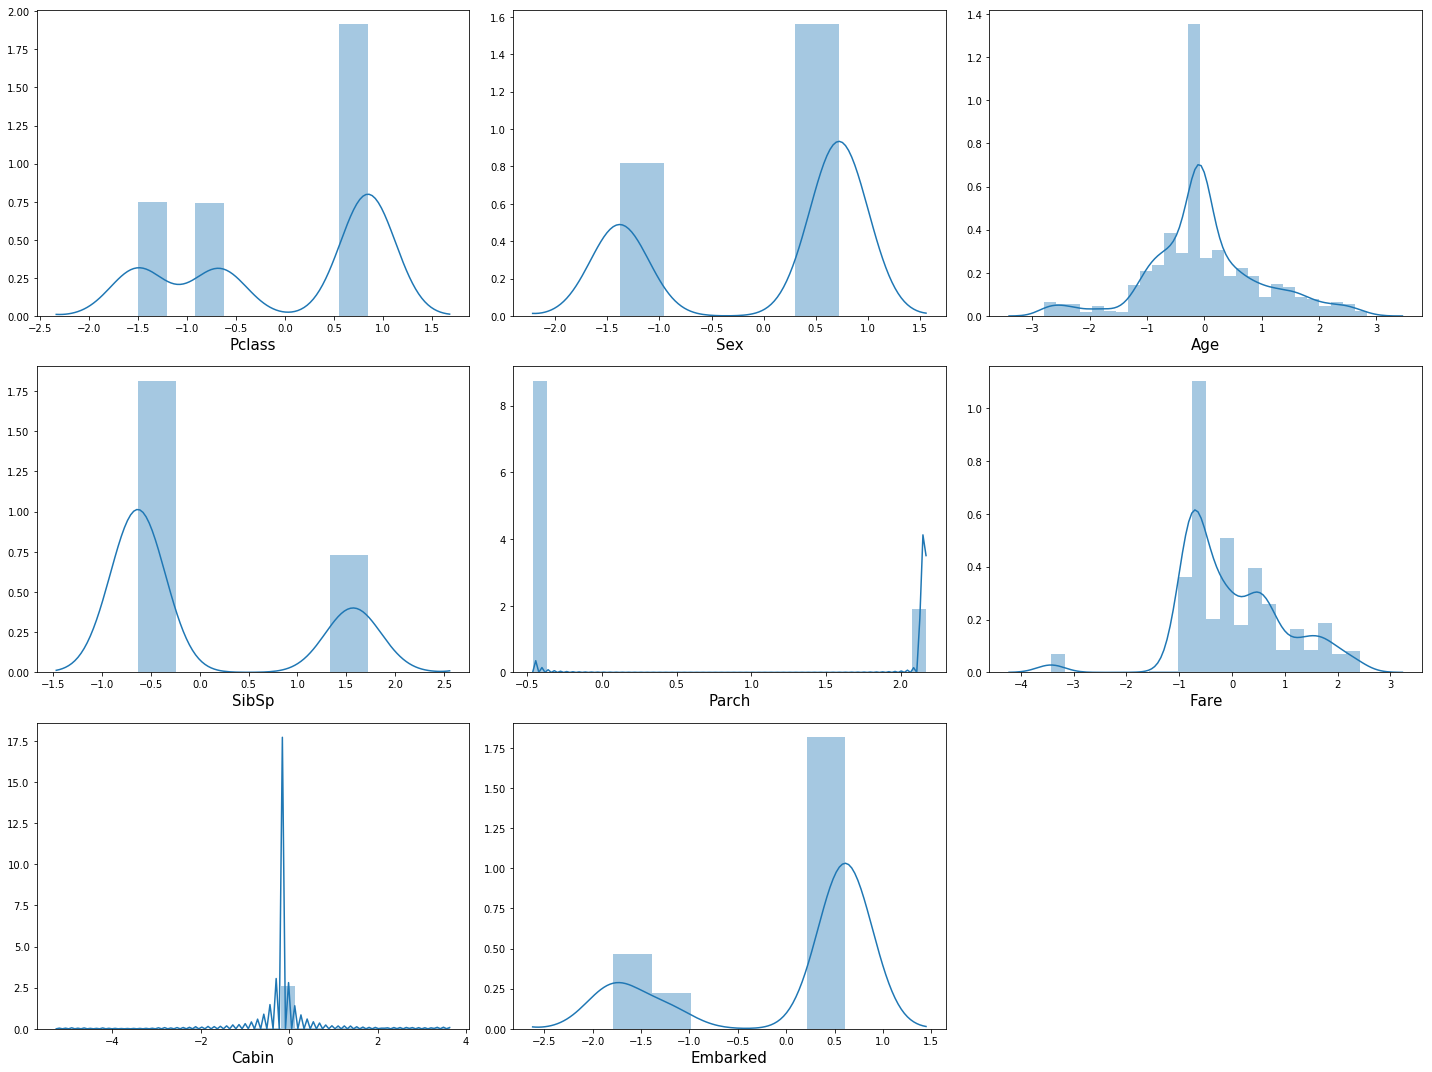

In [37]:
plt.figure(figsize = (20,15))
plotnum = 1

for i in x:
    if plotnum<= 9:
        sc = plt.subplot(3,3,plotnum)
        sns.distplot(x[i])
        plt.xlabel(i,fontsize = 15)
    plotnum+=1
plt.tight_layout()

### Although the column Fare has a correaltion of 0.26, we still see a lot of outlier and the skewness is also not removed. Therefore, i'm deciding to drop the column as the outliers are main reason for the correlation.

In [38]:
x = x.drop(columns = 'Fare',axis = 0)

#### Handling the class Imbalance in the dataset

In [39]:
from imblearn.over_sampling import SMOTE
sm =SMOTE()
x_over,y_over = sm.fit_resample(x,y)

####  Finding the best random state

In [40]:
for i in range(1,2000):
    x_train,x_test,y_train,y_test = train_test_split(x_over,y_over,random_state = i)
    lg = LogisticRegression()
    lg.fit(x_train,y_train)
    tr_pred = lg.predict(x_train)
    ts_pred = lg.predict(x_test)
    tr_score = accuracy_score(y_train,tr_pred)
    ts_score = accuracy_score(y_test,ts_pred)
    if round(tr_score*100,1)==round(ts_score*100,1):
        rs =i
print('The best random state is',rs)

The best random state is 1959


### Splitting the data with the default test size of 0.25 and using the best random state

In [41]:
x_train,x_test,y_train,y_test = train_test_split(x_over,y_over,random_state = rs)

### Model 1:  Logistic Regression

In [42]:
logr = LogisticRegression()
logr.fit(x_train,y_train)
log_pred = logr.predict(x_test)
log_acc = accuracy_score(y_test,log_pred)
log_acc

0.8024193548387096

#### the Accuracy score for the logistic regression model is 0.79

### Model 2:  Support vector Classifier

In [43]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(x_train,y_train)
svc_pred = svc.predict(x_test)
svc_acc =accuracy_score(y_test, svc_pred)
svc_acc

0.7983870967741935

#### the accuracy score for the support vecor classifier is 0.82

### Model 3:  AdaBoost Classifier

In [44]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
ada.fit(x_train,y_train)
ada_pred = ada.predict(x_test)
ada_acc = accuracy_score(y_test, ada_pred)
ada_acc

0.8024193548387096

#### the accuracy score for the  Adaboost Classifier is 0.81

### Model 4:  Random Forest Classifier

In [45]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x_train,y_train)
rf_pred = rf.predict(x_test)
rf_acc = accuracy_score(y_test,rf_pred)
rf_acc

0.7903225806451613

#### the accuracy score of random forest classifier is 0.84

### Model 5:  KNN Classifier

In [46]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(x_train,y_train)
knn_pred = knn.predict(x_test)
knn_acc = accuracy_score(y_test, knn_pred)
knn_acc

0.7943548387096774

#### the accuracy score of the KNN Classifier is 0.823

### Cross validatinf the models with the 7 fold cross validation

In [47]:
from sklearn.model_selection import cross_val_score
cv = cross_val_score(logr,x_over,y_over,cv = 7)
cv = cv.mean()
cv

0.7990567518586698

In [48]:
cv1 = cross_val_score(svc,x_over,y_over, cv =7)
cv1 = cv1.mean()
cv1

0.8081253478316708

In [49]:
cv2 = cross_val_score(ada,x_over,y_over,cv =7)
cv2 =cv2.mean()
cv2

0.7960386432067582

In [50]:
cv3 = cross_val_score(rf,x_over,y_over,cv =7)
cv3 =cv3.mean()
cv3

0.8152246814218647

In [51]:
cv4 = cross_val_score(knn,x_over,y_over,cv =7)
cv4 =cv4.mean()
cv4

0.8172795639082724

In [52]:
mod = [log_acc, svc_acc, ada_acc, rf_acc, knn_acc]
cv = [cv,cv1,cv2,cv3,cv4]
mod_sel =pd.DataFrame({})
mod_sel['mod'] = mod
mod_sel['cv'] = cv
mod_sel['diff'] = mod_sel['mod'] - mod_sel['cv']
mod_sel

,mod,cv,diff
0,0.802419,0.799057,0.003363
1,0.798387,0.808125,-0.009738
2,0.802419,0.796039,0.006381
3,0.790323,0.815225,-0.024902
4,0.794355,0.817280,-0.022925


### Upon reviewing, I see that the Logistic Regression gives the least differennce and it is the best model

## Hyper Parameter Tuning

In [65]:
params = {'penalty':['l1','l2','elasticnet','none'],
         'C':np.arange(0.001,1,0.01),
         'max_iter':[100,150,200,250],
         'n_jobs':[1,2,3,4,5,6]}

#### Using Grid Search to find the best parameters

In [66]:
gcv = GridSearchCV(LogisticRegression(),params,cv=7)
gcv.fit(x_train,y_train)

GridSearchCV(cv=7, estimator=LogisticRegression(),
             param_grid={'C': array([0.001, 0.011, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081,
       0.091, 0.101, 0.111, 0.121, 0.131, 0.141, 0.151, 0.161, 0.171,
       0.181, 0.191, 0.201, 0.211, 0.221, 0.231, 0.241, 0.251, 0.261,
       0.271, 0.281, 0.291, 0.301, 0.311, 0.321, 0.331, 0.341, 0.351,
       0.361, 0.371, 0.381, 0.391, 0.401, 0.411, 0.421, 0.431, 0.441,
       0.451, 0....
       0.541, 0.551, 0.561, 0.571, 0.581, 0.591, 0.601, 0.611, 0.621,
       0.631, 0.641, 0.651, 0.661, 0.671, 0.681, 0.691, 0.701, 0.711,
       0.721, 0.731, 0.741, 0.751, 0.761, 0.771, 0.781, 0.791, 0.801,
       0.811, 0.821, 0.831, 0.841, 0.851, 0.861, 0.871, 0.881, 0.891,
       0.901, 0.911, 0.921, 0.931, 0.941, 0.951, 0.961, 0.971, 0.981,
       0.991]),
                         'max_iter': [100, 150, 200, 250],
                         'n_jobs': [1, 2, 3, 4, 5, 6],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'

In [67]:
gcv.best_params_

{'C': 0.4009999999999999, 'max_iter': 100, 'n_jobs': 1, 'penalty': 'l2'}

### Final Model

In [69]:
fnl_log = LogisticRegression(C =0.4009999999999999,max_iter =100,n_jobs = 1, penalty ='l2')
fnl_log.fit(x_train,y_train)
fnl_pred = fnl_log.predict(x_test)
fnl_acc = accuracy_score(y_test,fnl_pred)
fnl_acc

0.8024193548387096

#### Looking at the classification report, I see that the model is balanced and hyper paameter tuning doesn't increase the score much hence saving the same model

In [70]:
class_rep = classification_report(y_test,fnl_pred)
print(class_rep)

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       120
           1       0.82      0.80      0.81       128

    accuracy                           0.80       248
   macro avg       0.80      0.80      0.80       248
weighted avg       0.80      0.80      0.80       248



In [71]:
roc_auc_score(y_test,fnl_pred)

0.8026041666666667

## ROC AUC Score

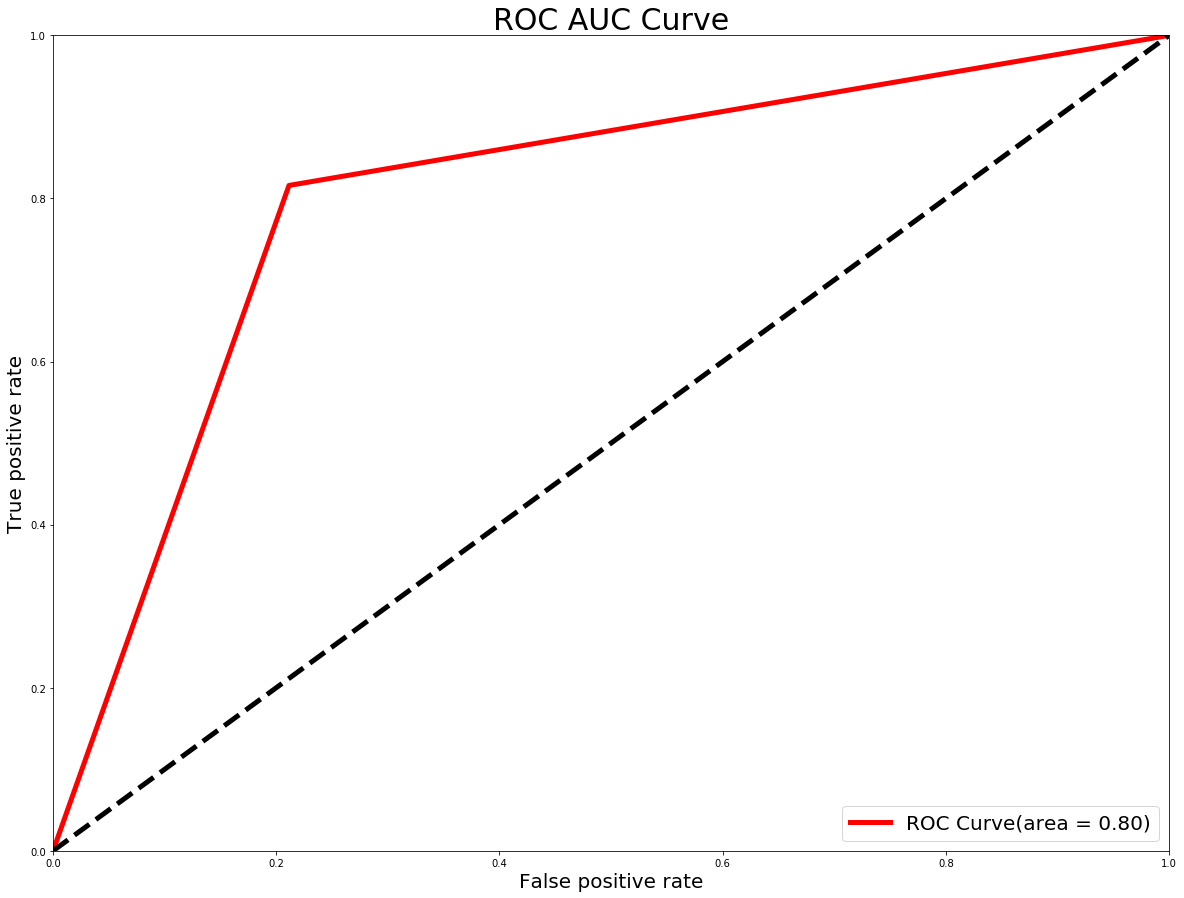

In [72]:
from sklearn.metrics import roc_curve, auc
fpr,tpr, thresholds = roc_curve(fnl_pred,y_test)
roc_auc = auc(fpr,tpr)

plt.figure(figsize = (20,15))
plt.plot(fpr,tpr,lw = 5, color = 'red',label = 'ROC Curve(area = %0.2f)'%roc_auc)
plt.plot([0,1],[0,1],lw =5, color ='black', linestyle = '--')
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.xlabel('False positive rate', fontsize = 20)
plt.ylabel('True positive rate', fontsize  =20)
plt.title('ROC AUC Curve', fontsize = 30)
plt.legend(loc ='lower right', fontsize = 20)
plt.show()

### Model Saving

In [73]:
import joblib
joblib.dump(fnl_knn, 'Titanic.pkl')

['Titanic.pkl']